<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/13_14_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [54]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [57]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [58]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [59]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [60]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


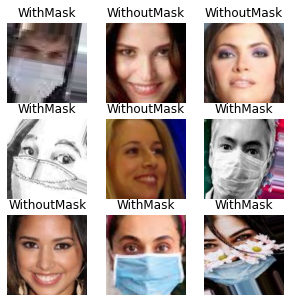

In [61]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [62]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 13

CNN

Input layer

Convolutional layer 1: 32 units, Relu activation - Maxpool Layer

Convolutional layer 2: 64 units, Relu activation - Maxpool Layer

Convolutional layer 3: 64 units Relu activation - Maxpool Layer 

Hidden Layer 1: 128 units, Relu Activation

Output layer: Dense 2 units, softmax activation


In [63]:
num_classes = 2

model13 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model13.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [64]:
history13 = model13.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 26s 78ms/step - loss: 0.1875 - accuracy: 0.9317 - val_loss: 0.0747 - val_accuracy: 0.9775
Epoch 2/41
313/313 [==============================] - 21s 66ms/step - loss: 0.0933 - accuracy: 0.9701 - val_loss: 0.0577 - val_accuracy: 0.9850
Epoch 3/41
313/313 [==============================] - 21s 66ms/step - loss: 0.0501 - accuracy: 0.9814 - val_loss: 0.0407 - val_accuracy: 0.9925
Epoch 4/41
313/313 [==============================] - 20s 65ms/step - loss: 0.0395 - accuracy: 0.9852 - val_loss: 0.0309 - val_accuracy: 0.9950
Epoch 5/41
313/313 [==============================] - 20s 65ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.0241 - val_accuracy: 0.9912
Epoch 6/41
313/313 [==============================] - 20s 65ms/step - loss: 0.0230 - accuracy: 0.9911 - val_loss: 0.1046 - val_accuracy: 0.9625
Epoch 7/41
313/313 [==============================] - 20s 65ms/step - loss: 0.0281 - accuracy: 0.9901 - val_loss: 0.0311 - val_accuracy:

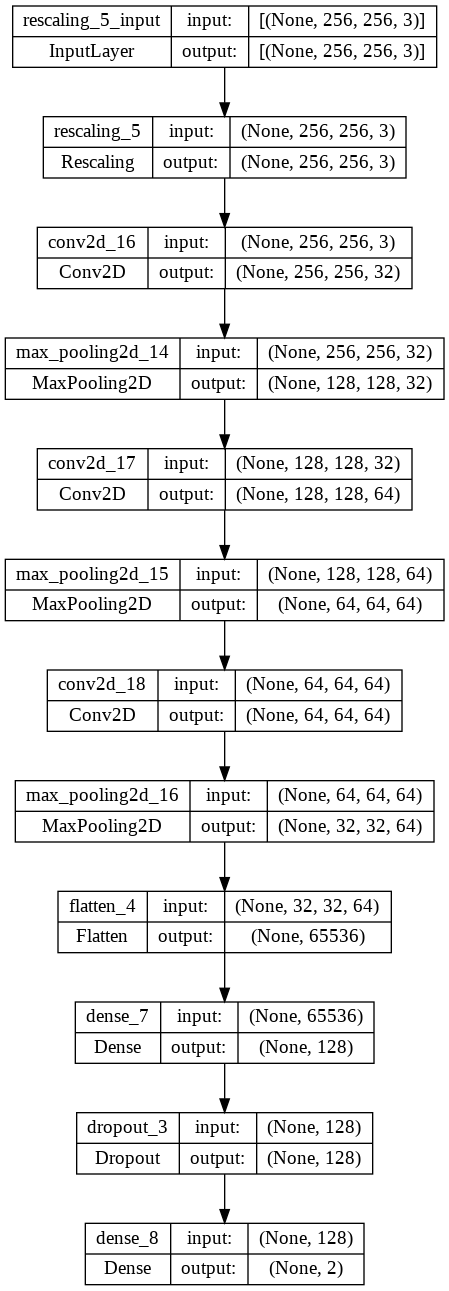

In [65]:
keras.utils.plot_model(model13, "model13.png", show_shapes=True) 

## Evaluate

In [66]:
history_dict13 = history13.history
history_dict13.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
history_df13 = pd.DataFrame(history_dict13)
history_df13.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
15,0.015,0.995,0.029,0.991
16,0.016,0.995,0.028,0.993
17,0.003,0.999,0.026,0.995
18,0.006,0.998,0.046,0.990
19,0.007,0.998,0.025,0.996


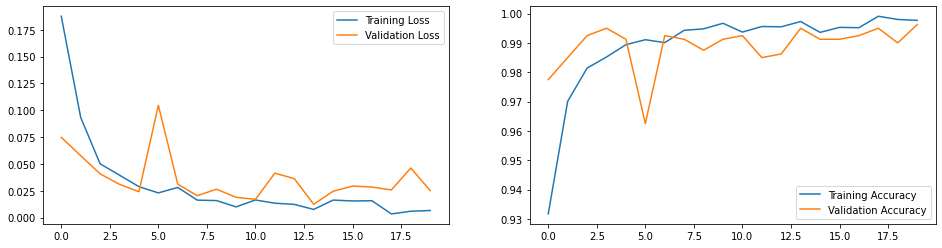

In [68]:
## Loss and acuracy
plot_history(history13)

In [69]:
test_pred13 = model13.predict(test_ds)
test_pred13 = np.argmax(test_pred13,axis = 1)
test_labels13 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 2s 44ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

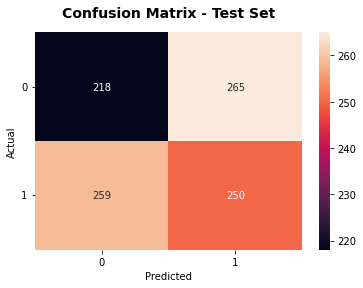

In [70]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels13,
    test_pred13,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [71]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 259 with mask and 265 without mask

In [72]:
import numpy
from sklearn import metrics

actual13 = test_labels13
predicted13 = test_pred13

Accuracy = metrics.accuracy_score(actual13, predicted13)
Precision = metrics.precision_score(actual13, predicted13)
Sensitivity_recall = metrics.recall_score(actual13, predicted13)
Specificity = metrics.recall_score(actual13, predicted13, pos_label=0)
F1_score = metrics.f1_score(actual13, predicted13)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.4717741935483871, 'Precision': 0.4854368932038835, 'Sensitivity_recall': 0.4911591355599214, 'Specificity': 0.45134575569358176, 'F1_score': 0.48828125}


In [73]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual13, predicted13, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.46      0.45      0.45       483
 withoutMask       0.49      0.49      0.49       509

    accuracy                           0.47       992
   macro avg       0.47      0.47      0.47       992
weighted avg       0.47      0.47      0.47       992



# Model 14

CNN

Input layer

Convolutional layer 3: 128 units Relu activation 

Maxpool Layer 32x32

Convolutional layer 4: 256 units, Relu activation 

Maxpool Layer 16x16

Hidden Layer 1: 256 units, Relu Activation

Output layer: Dense 2 units, sigmoid activation


In [74]:
num_classes = 2

model14 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model14.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [75]:
history14 = model14.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 15s 45ms/step - loss: 0.1497 - accuracy: 0.9428 - val_loss: 0.1102 - val_accuracy: 0.9638
Epoch 2/41
313/313 [==============================] - 14s 44ms/step - loss: 0.0633 - accuracy: 0.9788 - val_loss: 0.0496 - val_accuracy: 0.9850
Epoch 3/41
313/313 [==============================] - 14s 44ms/step - loss: 0.0429 - accuracy: 0.9839 - val_loss: 0.0749 - val_accuracy: 0.9775
Epoch 4/41
313/313 [==============================] - 14s 45ms/step - loss: 0.0370 - accuracy: 0.9866 - val_loss: 0.0221 - val_accuracy: 0.9887
Epoch 5/41
313/313 [==============================] - 14s 44ms/step - loss: 0.0282 - accuracy: 0.9905 - val_loss: 0.0358 - val_accuracy: 0.9887
Epoch 6/41
313/313 [==============================] - 14s 44ms/step - loss: 0.0173 - accuracy: 0.9932 - val_loss: 0.0084 - val_accuracy: 0.9950
Epoch 7/41
313/313 [==============================] - 14s 44ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0128 - val_accuracy:

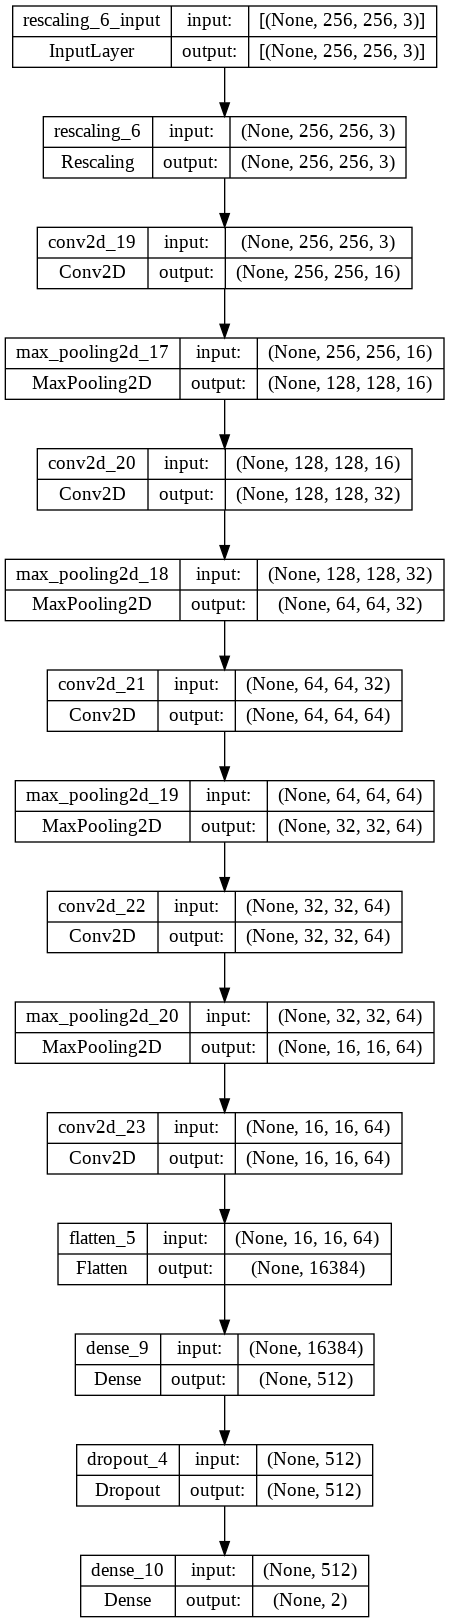

In [76]:
keras.utils.plot_model(model14, "model14.png", show_shapes=True) 

## Evaluate

In [77]:
history_dict14 = history14.history
history_dict14.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [78]:
history_df14 = pd.DataFrame(history_dict14)
history_df14.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.013,0.995,0.023,0.991
8,0.022,0.992,0.022,0.990
9,0.010,0.997,0.024,0.993
10,0.012,0.996,0.010,0.999
11,0.008,0.997,0.027,0.988


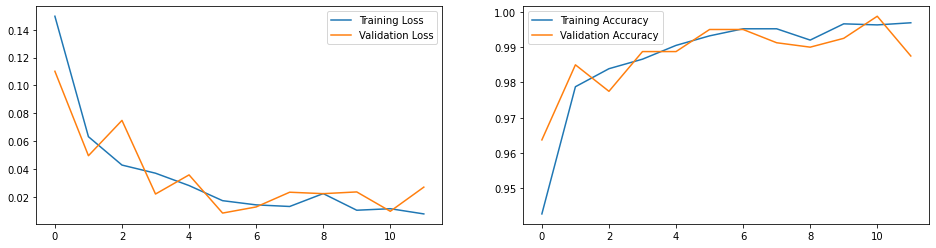

In [79]:
## Loss and acuracy
plot_history(history14)

In [80]:
test_pred14 = model14.predict(test_ds)
test_pred14 = np.argmax(test_pred14,axis = 1)
test_labels14 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 2s 40ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

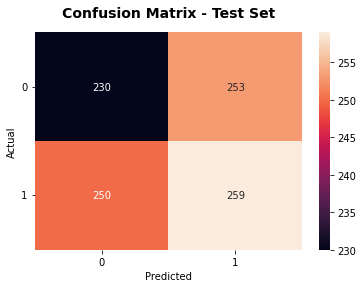

In [81]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels14,
    test_pred14,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [82]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 259 with mask and 253 without mask

In [83]:
actual14 = test_labels14
predicted14 = test_pred14

Accuracy = metrics.accuracy_score(actual14, predicted14)
Precision = metrics.precision_score(actual14, predicted14)
Sensitivity_recall = metrics.recall_score(actual14, predicted14)
Specificity = metrics.recall_score(actual14, predicted14, pos_label=0)
F1_score = metrics.f1_score(actual14, predicted14)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.49294354838709675, 'Precision': 0.505859375, 'Sensitivity_recall': 0.5088408644400786, 'Specificity': 0.47619047619047616, 'F1_score': 0.5073457394711067}


In [84]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual14, predicted14, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.48      0.48      0.48       483
 withoutMask       0.51      0.51      0.51       509

    accuracy                           0.49       992
   macro avg       0.49      0.49      0.49       992
weighted avg       0.49      0.49      0.49       992

